In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import title
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Импортируем данные из файла

In [44]:
df = pd.read_csv('data/HR.csv')

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Посчитаем количество пропусков

In [45]:
print(df.isnull().sum())

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64


Пропусков нет

In [46]:
print(df.dtypes)

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object


Все признаки числовые кроме *salary* и *department*

Найдем количество людей, покинувших компанию

In [47]:
print(df['left'].value_counts())

left
0    11428
1     3571
Name: count, dtype: int64


In [48]:
df.drop(['salary', 'department'], axis=1).groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Видим, что уровень удовлетворенности у ушедших ниже, чем у оставшихся (логично 🧐).
`last_evaluation` одинаков для обеих категорий и вряд ли на что-то влияет, его можно отбросить

In [49]:
df.drop('last_evaluation', axis=1, inplace=True)

Рассмотрим текучесть кадров по отделам

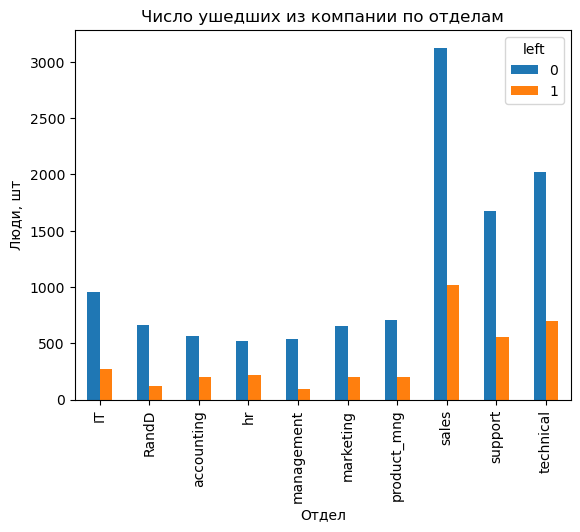

In [50]:
pd.crosstab(df['department'], df['left']).plot(kind='bar')
plt.title('Число ушедших из компании по отделам')
plt.xlabel('Отдел')
plt.ylabel('Люди, шт')
plt.show()

Как видно, чаще всего уходят из отдела продаж, поддержки и технического
Далее проанализируем влияние зарплаты на уход

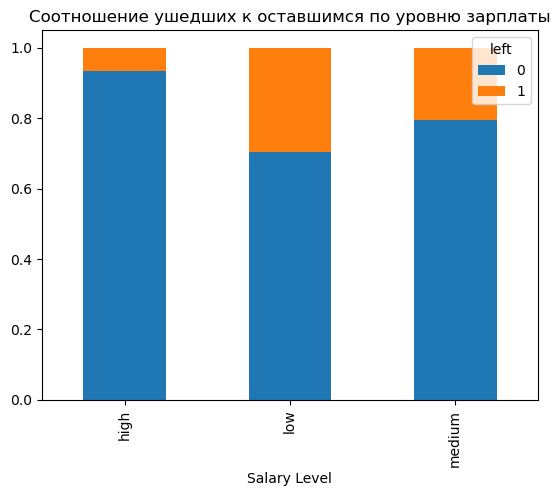

In [51]:
table = pd.crosstab(df['salary'], df['left'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Соотношение ушедших к оставшимся по уровню зарплаты')
plt.xlabel('Salary Level')
plt.show()

Закодируем категориальные признаки

In [52]:
df_encoded = pd.get_dummies(df, columns=['department'])

ord_encoder = OrdinalEncoder()
ord_encoder.fit(df[['salary']])
df_encoded[['salary']] = ord_encoder.fit_transform(df_encoded[['salary']])

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      14999 non-null  float64
 1   number_project          14999 non-null  int64  
 2   average_montly_hours    14999 non-null  int64  
 3   time_spend_company      14999 non-null  int64  
 4   work_accident           14999 non-null  int64  
 5   left                    14999 non-null  int64  
 6   promotion_last_5years   14999 non-null  int64  
 7   salary                  14999 non-null  float64
 8   department_IT           14999 non-null  bool   
 9   department_RandD        14999 non-null  bool   
 10  department_accounting   14999 non-null  bool   
 11  department_hr           14999 non-null  bool   
 12  department_management   14999 non-null  bool   
 13  department_marketing    14999 non-null  bool   
 14  department_product_mng  14999 non-null

Далее удаляем строки, в которых указаны не уволившиеся люди и отбрасываем столбец *left*

In [53]:
df_left = df_encoded[df_encoded['left'] == 1]

X = df_encoded.drop('left', axis=1)
y = df_encoded['left']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      14999 non-null  float64
 1   number_project          14999 non-null  int64  
 2   average_montly_hours    14999 non-null  int64  
 3   time_spend_company      14999 non-null  int64  
 4   work_accident           14999 non-null  int64  
 5   promotion_last_5years   14999 non-null  int64  
 6   salary                  14999 non-null  float64
 7   department_IT           14999 non-null  bool   
 8   department_RandD        14999 non-null  bool   
 9   department_accounting   14999 non-null  bool   
 10  department_hr           14999 non-null  bool   
 11  department_management   14999 non-null  bool   
 12  department_marketing    14999 non-null  bool   
 13  department_product_mng  14999 non-null  bool   
 14  department_sales        14999 non-null

Далее проведем масштабирование данных

In [54]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

,satisfaction_level,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,-0.936495,-1.462863,-0.882040,-0.341235,-0.411165,-0.147412,-0.554955,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
1,0.752814,0.971113,1.220423,1.713436,-0.411165,-0.147412,1.043004,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
2,-2.022479,2.593763,1.420657,0.343655,-0.411165,-0.147412,1.043004,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
3,0.431041,0.971113,0.439508,1.028546,-0.411165,-0.147412,-0.554955,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
4,-0.976716,-1.462863,-0.841993,-0.341235,-0.411165,-0.147412,-0.554955,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655


Кластеризация методом Kmeans

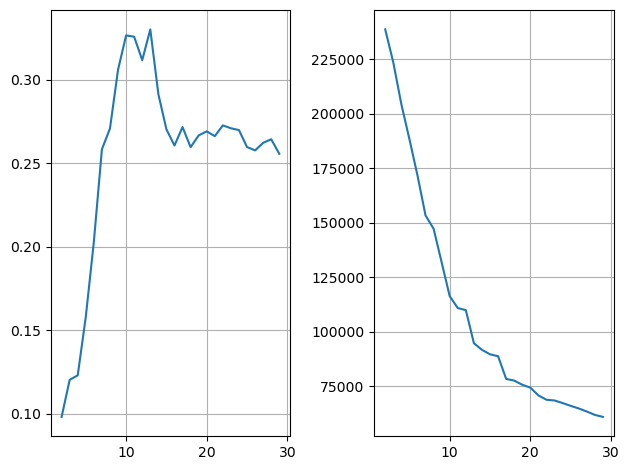

In [55]:
inertia = []
silhouettes = []

iter_max = 30

for k in range(2, iter_max):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    predicted = kmeans.predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, predicted)

    silhouettes.append(silhouette_avg)
    inertia.append(-kmeans.score(X_scaled))

fig, axs = plt.subplots(1, 2)
axs[0].plot(range(2, iter_max), silhouettes, label='Silhouette')
axs[0].grid(True)

axs[1].plot(range(2, iter_max), inertia, label='Inertia')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Метод локтя не показал адекватного результата, методом силуэтом определяется 10 или 13 кластеров

In [57]:
optimal_k = 10

DBSCAN

In [58]:
from sklearn.neighbors import NearestNeighbors


def draw_dbscan_curve(X_dbscan, n=5):
    nearest = NearestNeighbors(n_neighbors=n)
    neighbors = nearest.fit(X_dbscan)
    distances, indices = neighbors.kneighbors(X_dbscan)
    distances = np.sort(distances[:, -1])

    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel('Объекты')
    plt.ylabel('Расстояние до 5-го ближайшего соседа')
    plt.title('Определение оптимального эпсилон для DBSCAN')
    plt.grid(True)
    plt.show()

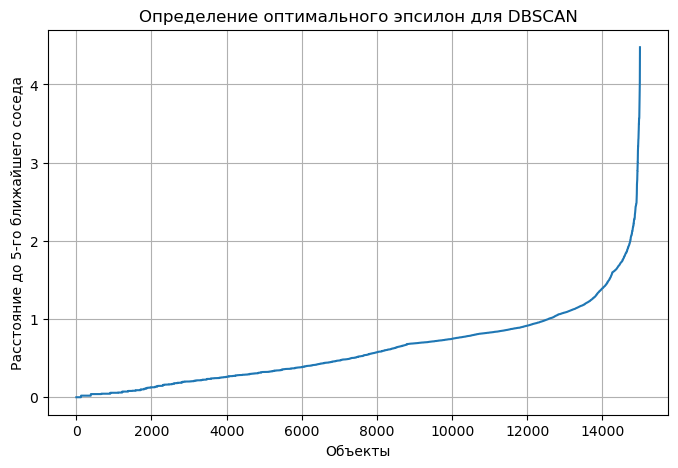

In [59]:
draw_dbscan_curve(X_scaled)

In [60]:
optimal_e = 1.8

Обучим модель К-средних и выведем кластеры на график

In [67]:
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters_k = kmeans_optimal.fit_predict(X_scaled)
unique_c_k = np.unique(clusters_k)

clusters_k.shape

(14999,)

In [68]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [69]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

In [36]:
print(unique_c_k)

[0 1 2 3 4 5 6 7 8 9]


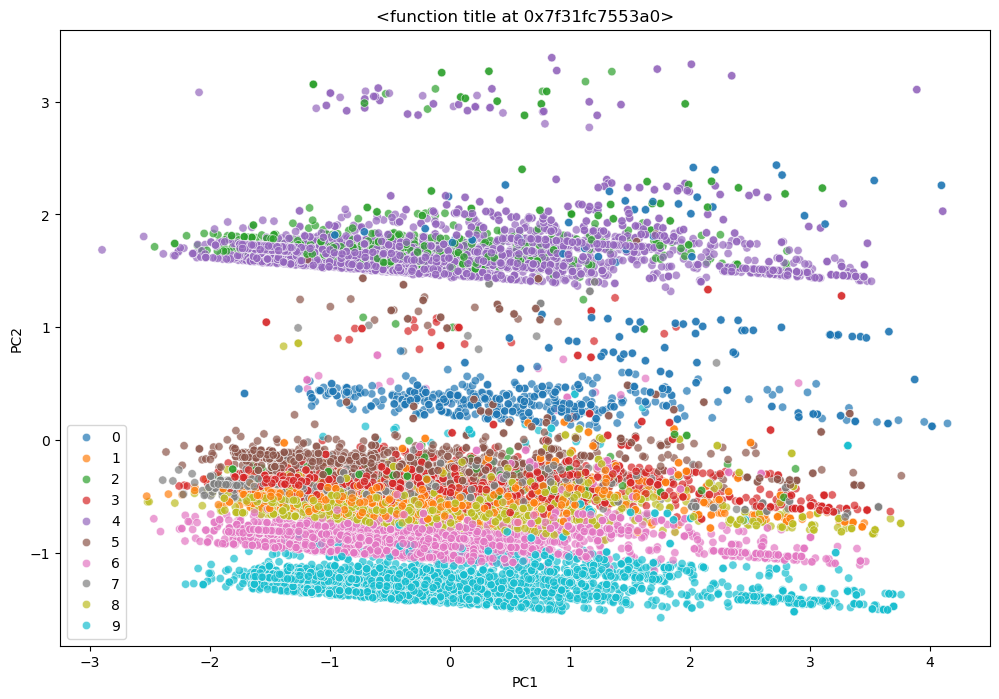

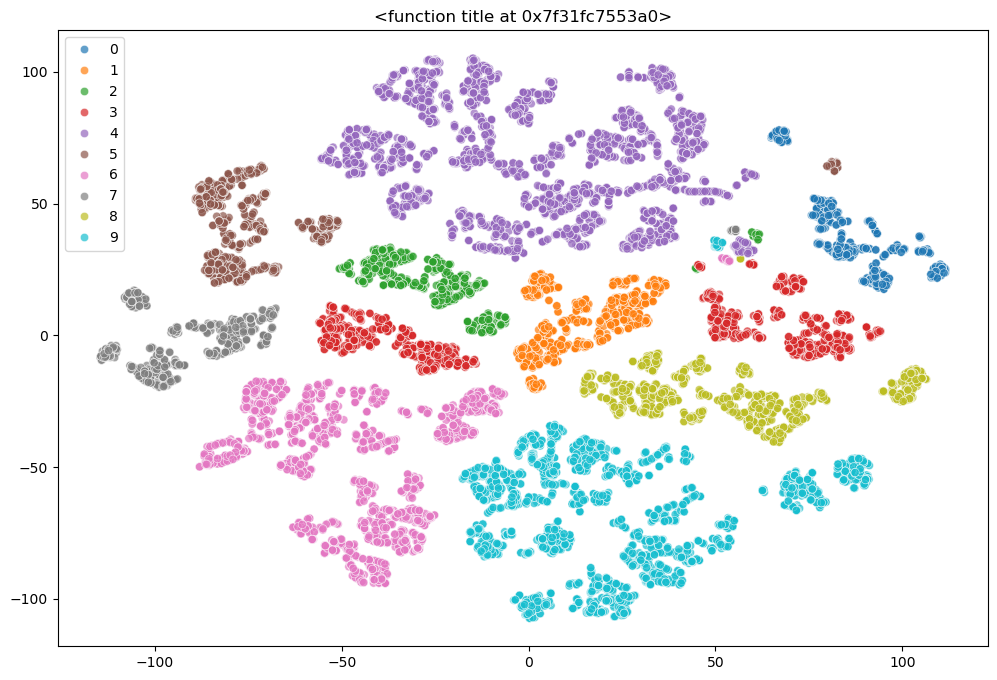

In [75]:
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = clusters_k

plt.figure(figsize=(12, 8))
sns.scatterplot(x="PC1", y="PC2", hue="label", palette="tab10", data=pca_df,alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters_k, palette="tab10", alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()

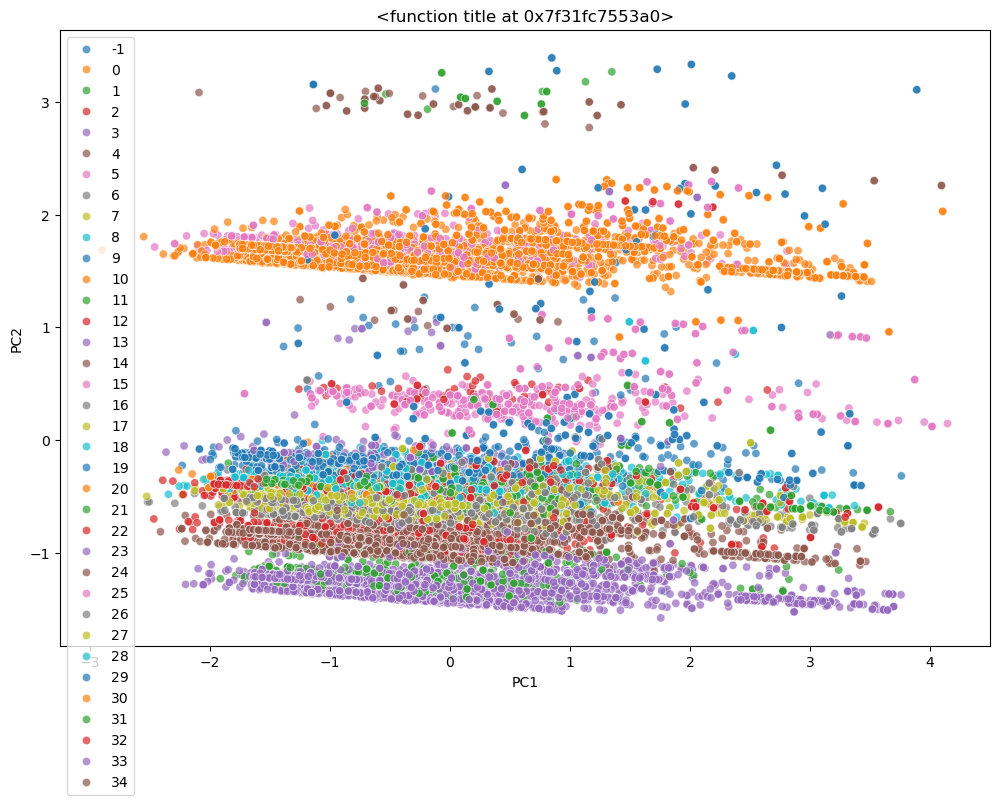

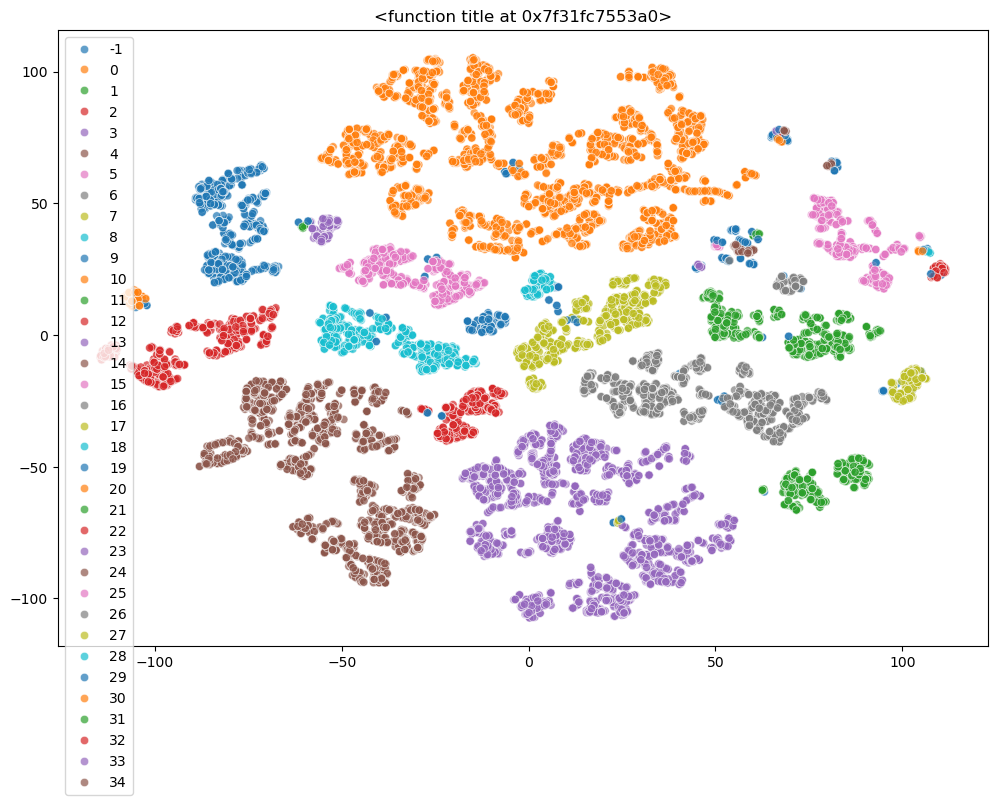

In [76]:
dbscan_optimal = DBSCAN(eps=optimal_e)
clusters_db = dbscan_optimal.fit_predict(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = clusters_db

plt.figure(figsize=(12, 8))
sns.scatterplot(x="PC1", y="PC2", hue="label", palette="tab10", data=pca_df,alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters_db, palette="tab10", alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()